In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
from step7.Ecommerce7 import*

## Step 3

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [13:21<00:00,  8.01s/it]


Experiment n°: 2


n_iteration: 100%|██████████| 100/100 [20:37<00:00, 12.37s/it]


Experiment n°: 3


n_iteration: 100%|██████████| 100/100 [16:47<00:00, 10.08s/it]


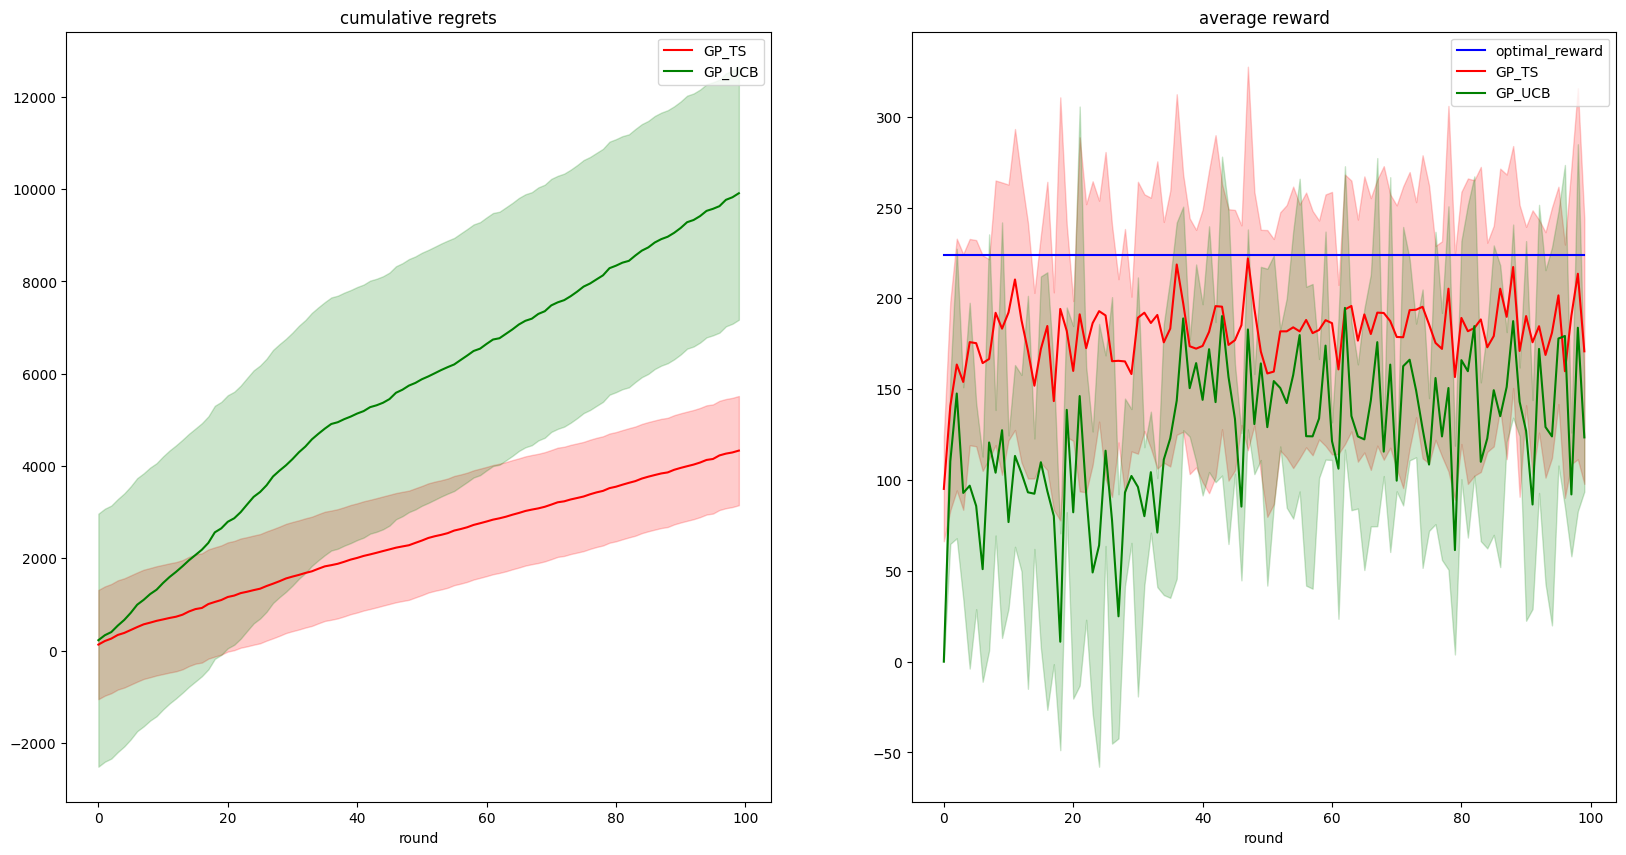

In [2]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GP_TS", "GP_UCB"])

## Step 4

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GP_TS", "GP_UCB"])

## Step 5

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GP_TS", "GP_UCB"])

## Step 6

In [ ]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SW_UCB", "CD_UCB"])

## Step 7

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GP_TS", "GP_UCB"])